In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('/Users/ayushbhupal/Desktop/UChicago/Classes/Fixed Income and Derivatives/treasury_quotes_2025-11-28.xlsx', sheet_name='selected quotes')
df

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
0,208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
1,208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
2,208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
3,208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
4,208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588
5,208145,note,2025-11-28,2023-11-30,2028-11-30,3.006160,0.989071,4.375,102.437500,102.472656,102.455078,2.163593,104.618671,0.035065,5.553400e+10,2.794544
6,208229,note,2025-11-28,2024-05-31,2029-05-31,3.504449,0.989071,4.500,103.171875,103.207031,103.189453,2.225410,105.414863,0.035258,7.415600e+10,3.218036
7,208318,note,2025-11-28,2024-11-30,2029-11-30,4.005476,0.989071,4.125,102.078125,102.132812,102.105469,2.039959,104.145428,0.035564,7.476100e+10,3.665596
8,208401,note,2025-11-28,2025-05-31,2030-05-31,4.503765,0.989071,4.000,101.730469,101.785156,101.757812,1.978142,103.735955,0.035754,7.958200e+10,4.092696
9,208486,note,2025-11-28,2025-11-30,2030-11-30,5.004791,0.000000,3.500,99.546875,99.554688,99.550781,0.000000,99.550781,0.035953,NaN,4.637183


# 1.1 Bootstrap the Spot Curve

In [3]:
df = df.sort_values("ttm").reset_index(drop=True)

def bond_cashflows(ttm, coupon_rate, freq=2, face=100):
    n = int(round(ttm * freq))
    times = np.array([(i + 1) / freq for i in range(n)])
    coupons = np.full(n, face * coupon_rate / 100 / freq)
    coupons[-1] += face
    return times, coupons

spot_rates = {}
Discount_factors = {}

for _, row in df.iterrows():

    times, cfs = bond_cashflows(row["ttm"], row["cpn rate"])
    price = row["dirty price"]

    pv_known = 0.0

    for t, cf in zip(times[:-1], cfs[:-1]):
        z = spot_rates[round(t, 6)]
        pv_known += cf / (1 + z) ** t

    # solve for the unknown spot rate
    t_last = times[-1]
    cf_last = cfs[-1]

    D_last = (price - pv_known)/cf_last
    z_last = (1 / D_last) ** (1 / t_last) - 1
    spot_rates[round(t_last, 6)] = z_last
    Discount_factors[round(t_last, 6)] = D_last
    
spot_curve = (
    pd.DataFrame(
        {"ttm": list(spot_rates.keys()),
         "spot_rate": list(spot_rates.values()),
         "discount_factor": list(Discount_factors.values())}
    )
    .sort_values("ttm")
    .reset_index(drop=True)
)

spot_curve["r_cont"] = -np.log(spot_curve["discount_factor"]) / spot_curve["ttm"]
m = 2
spot_curve["r_semi"] = m * (spot_curve["discount_factor"] ** (-1 / (m * spot_curve["ttm"])) - 1)
spot_curve

,ttm,spot_rate,discount_factor,r_cont,r_semi
0,0.5,-0.009685,1.004878,-0.009732,-0.009708
1,1.0,0.015680,0.984562,0.015558,0.015619
2,1.5,0.022962,0.966520,0.022702,0.022831
3,2.0,0.035802,0.932065,0.035176,0.035487
4,2.5,0.027796,0.933755,0.027417,0.027605
5,3.0,0.027970,0.920573,0.027586,0.027778
6,3.5,0.029063,0.904592,0.028649,0.028855
7,4.0,0.030697,0.886086,0.030235,0.030465
8,4.5,0.031612,0.869313,0.031123,0.031366
9,5.0,0.037003,0.833874,0.036335,0.036667


1. Discount Rate for Maturity T = 5 is 0.833874
2. Semi-annually compounded spot rate = 0.036667
3. Coninuously compounded spot rate = 0.036335

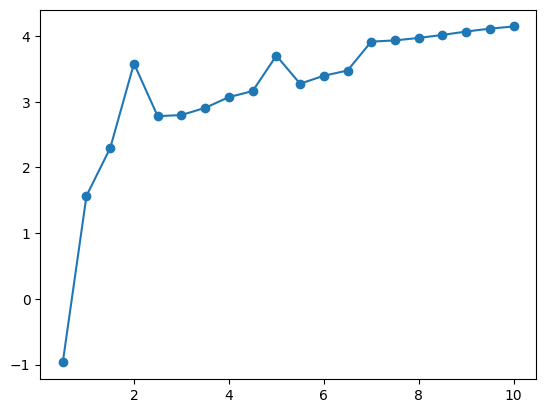

In [4]:
plt.plot(spot_curve["ttm"], spot_curve["spot_rate"] * 100, marker='o')

# 1.2 Forward Discount Factors

In [5]:
# 6-month forward discount factors and forward rates
fwd_DF = []
fwd_rates_semiannual = []
fwd_rates_continuous = []
for i in range(1, len(spot_curve)):
    t1 = spot_curve.loc[i - 1, "ttm"]
    t2 = spot_curve.loc[i, "ttm"]
    D1 = spot_curve.loc[i - 1, "discount_factor"]
    D2 = spot_curve.loc[i, "discount_factor"]
    
    fwd_D = D2 / D1
    fwd_DF.append(fwd_D)
    
    # semi-annual compounding
    fwd_r_semi = m * (fwd_D ** (-1 / (m * (t2 - t1))) - 1)
    fwd_rates_semiannual.append(fwd_r_semi)
    
    # continuous compounding
    fwd_r_cont = -np.log(fwd_D) / (t2 - t1)
    fwd_rates_continuous.append(fwd_r_cont)

fwd_curve = pd.DataFrame({
    "start_ttm": spot_curve["ttm"][:-1],
    "fwd_discount_factor": fwd_DF,
    "fwd_rate_semiannual": fwd_rates_semiannual,
    "fwd_rate_continuous": fwd_rates_continuous
})
fwd_curve

,start_ttm,fwd_discount_factor,fwd_rate_semiannual,fwd_rate_continuous
0,0.5,0.979783,0.041268,0.040848
1,1.0,0.981675,0.037334,0.036990
2,1.5,0.964351,0.073933,0.072599
3,2.0,1.001813,-0.003619,-0.003622
4,2.5,0.985883,0.028639,0.028436
5,3.0,0.982641,0.035332,0.035023
6,3.5,0.979541,0.041772,0.041342
7,4.0,0.981071,0.038589,0.038221
8,4.5,0.959234,0.084998,0.083241
9,5.0,1.004526,-0.009012,-0.009032


In [6]:
# TABLE FOR FWD Curve of ttm=5 and ttm=5.5 YEARS

fwd_curve_selected = fwd_curve[(fwd_curve["start_ttm"] >= 5) & (fwd_curve["start_ttm"] <= 5.5)].reset_index(drop=True)
fwd_curve_selected

,start_ttm,fwd_discount_factor,fwd_rate_semiannual,fwd_rate_continuous
0,5.0,1.004526,-0.009012,-0.009032
1,5.5,0.977116,0.046841,0.046301


# 1.3 Forward Curve Analysis

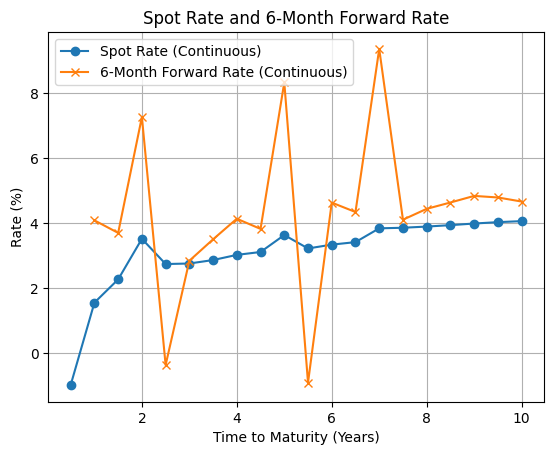

In [7]:
# plot the spot rate and the 6-month forward rate on the same axes
plt.plot(spot_curve["ttm"], spot_curve["r_cont"] * 100, marker='o', label='Spot Rate (Continuous)')
plt.plot(fwd_curve["start_ttm"] + 0.5, fwd_curve["fwd_rate_continuous"] * 100, marker='x', label='6-Month Forward Rate (Continuous)')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Rate (%)')
plt.title('Spot Rate and 6-Month Forward Rate')
plt.legend()
plt.grid()
plt.show()

The forward rate is highest for the 6-month interval from 6.5 to 7.0 years. The forward rate is 0.09353786 or 9.35% (continuous compounding) for this interval.

Forward above spot means the spot curve must be rising at that maturity. If the forward rate is above the spot rate, then the spot curve is locally upward-sloping. Yield curve steepens.